# Initialize

In [2]:
# Authors: Martin Luessi <mluessi@nmr.mgh.harvard.edu>
#          Alexandre Gramfort <alexandre.gramfort@inria.fr>
#          Nicolas P. Rougier (graph code borrowed from his matplotlib gallery)
#
# License: BSD (3-clause)

import numpy as np
import os.path as op
import os
import matplotlib.pyplot as plt
from langouEEG import *
from scipy.stats import *
from IPython.display import clear_output as clear

import mne
import pickle
from mne.datasets import sample
from mne.minimum_norm import apply_inverse_epochs, read_inverse_operator
from mne.connectivity import spectral_connectivity, envelope_correlation
from mne.viz import circular_layout, plot_connectivity_circle
import mne
from mne.datasets import eegbci
from mne.datasets import fetch_fsaverage
from mne.datasets import sample
from mne.minimum_norm import make_inverse_operator, apply_inverse
from mne.minimum_norm import write_inverse_operator

import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa
import mne

# !export DISPLAY=localhost:14.0
# !export MESA_GL_VERSION_OVERRIDE=3.3
# import pyvista
# pyvista.start_xvfb()

sample_data_folder = mne.datasets.sample.data_path()
dataRoot = "/work/zhangyq/Light"
# Download fsaverage files
fs_dir = fetch_fsaverage(verbose=True)
isMale = False
isAll = True
isBlind = False
if not isAll:
    result_dir = op.join(dataRoot,'result','male' if isMale else 'female')
else:
    result_dir = op.join(dataRoot,'result','all')
if isBlind:
    result_dir = op.join(result_dir,'Blind')
subjects_dir = op.dirname(fs_dir)
if not op.exists(result_dir):
    os.mkdir(result_dir)
# The files live in:
subject = 'fsaverage'
trans = 'fsaverage'  # MNE has a built-in fsaverage transformation
src = op.join(fs_dir, 'bem', 'fsaverage-ico-5-src.fif')
bem = op.join(fs_dir, 'bem', 'fsaverage-5120-5120-5120-bem-sol.fif')
print(__doc__)

0 files missing from root.txt in /work/zhangyq/mne_data/MNE-fsaverage-data
0 files missing from bem.txt in /work/zhangyq/mne_data/MNE-fsaverage-data/fsaverage
Automatically created module for IPython interactive environment


# Load data

In [3]:
%%capture
epochs_4F = dict()
epochs_RF = dict()
epochs_4R = dict()
epochs_RR = dict()
for subject_name in range(1,21):
    if not isAll:
        if not (isMale ^ (subject_name in [7,8,11,17])):
            continue
    if subject_name<10:
        subject_name='S0'+str(subject_name)
    else:
        subject_name='S'+str(subject_name)
    with open(dataRoot+'/clean_data_av/'+subject_name+'_clean.lgeeg','rb') as f:
        raw=pickle.load(f)
    events, event_dict=extractEvents(raw)
    picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=True,
                        exclude='bads')
    if isBlind:
        epoch_RR,epoch_RF,epoch_4R,epoch_4F = extractEpochsBlind(raw,events,picks)
    else:
        epoch_RR,epoch_RF,epoch_4R,epoch_4F = extractEpochs(raw,events,picks)
    epochs_4F[subject_name]=epoch_4F
    epochs_RF[subject_name]=epoch_RF
    epochs_RR[subject_name]=epoch_RR
    epochs_4R[subject_name]=epoch_4R
    if not op.exists(os.path.join(dataRoot,'fwd_solution.lgeeg')):
        fwd = mne.make_forward_solution(raw.info, trans=trans, src=src,
                                        bem=bem, eeg=True, mindist=5.0, n_jobs=1)
        print(fwd)
        mne.write_forward_solution(os.path.join(dataRoot,'fwd_solution.lgeeg'),fwd,overwrite=True)
    else:
        fwd = mne.read_forward_solution(os.path.join(dataRoot,'fwd_solution.lgeeg'))
    data_path = sample.data_path()

    picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=True,
                        exclude='bads')

 




# Source Estimation


In [4]:
%%capture
cons_40 = []
cons_rand = []
act_40 = []
act_40_paired = []
act_rand = []
act_rand_paired = []
avg_stc_40 = None
avg_stc_rand = None
result_root= result_dir
fname_avg_stc_4F = op.join(result_dir,'avg_stc_4F.lgeeg')
fname_avg_stc_RF = op.join(result_dir,'avg_stc_RF.lgeeg')
for subject_name,_ in epochs_4F.items():
    # Compute inverse solution and for each epoch. By using "return_generator=True"
    # stcs will be a generator object instead of a list.
    result_dir = op.join(result_root,subject_name)
    epoch_4F = epochs_4F[subject_name]
    epoch_RF = epochs_RF[subject_name]
    fname_stc_4F = op.join(result_dir,subject_name+'_stc_4F.lgeeg')
    fname_stc_RF = op.join(result_dir,subject_name+'_stc_RF.lgeeg')
    fname_tl_4F = op.join(result_dir,subject_name+'_tl_4F.lgeeg')
    fname_tl_RF = op.join(result_dir,subject_name+'_tl_RF.lgeeg')
    fname_inv = os.path.join(dataRoot,'inv_operators',subject_name+'_inv.lgeeg')
    

    if not os.path.exists(result_dir):
        os.mkdir(result_dir)



    fname_inv_r = os.path.join(dataRoot,'inv_operators',subject_name+'_r_inv.lgeeg')
    fname_cov_r = os.path.join(dataRoot,'noise_covariance',subject_name+'_r_cov.lgeeg')
    fname_inv_4 = os.path.join(dataRoot,'inv_operators',subject_name+'_4_inv.lgeeg')
    fname_cov_4 = os.path.join(dataRoot,'noise_covariance',subject_name+'_4_cov.lgeeg')



    if not os.path.exists(fname_cov_4):  
        noise_cov = mne.compute_covariance(
            epochs_4R[subject_name], tmax=80., method=['shrunk', 'empirical'], rank=None, verbose=True)
        mne.write_cov(fname_cov_4,noise_cov)
    else:   
    # Load data
        noise_cov = mne.read_cov(fname_cov_4)
    
    if not os.path.exists(fname_inv_4):  
        inverse_operator = make_inverse_operator(
            raw.info, fwd, noise_cov, loose=0.2, depth=0.8)
        write_inverse_operator(fname_inv_4,inverse_operator)
    inverse_operator = read_inverse_operator(fname_inv_4)



    snr = 1.0  # use lower SNR for single epochs
    lambda2 = 1.0 / snr ** 2
    method = "dSPM"  # use dSPM method (could also be MNE or sLORETA)
    # Get labels for FreeSurfer 'aparc' cortical parcellation with 34 labels/hemi
    labels = mne.read_labels_from_annot('fsaverage', parc='aparc',
                                        subjects_dir=subjects_dir)[:68]
    label_colors = [label.color for label in labels]
    # Average the source estimates within each label using sign-flips to reduce
    # signal cancellations, also here we return a generator
    src = inverse_operator['src']
#=====STC======

    if op.exists(fname_stc_4F):
        with open(fname_stc_4F,'rb') as f :
            stcs = pickle.load(f)
        print(subject_name+' loaded')
    else:
        stcs = apply_inverse_epochs(epoch_4F, inverse_operator, lambda2, method,
                                    pick_ori="normal", return_generator=False)
        with open(fname_stc_4F,'wb') as f:
            pickle.dump(stcs,f)
    if not op.exists(fname_avg_stc_4F):
        if avg_stc_40 is None:
            avg_stc_40 = np.mean(stcs)
        else:
            avg_stc_40 = np.mean([np.mean(stcs),avg_stc_40])
#======Time Label=====
    if op.exists(fname_tl_4F):
        with open(fname_tl_4F,'rb') as f:
            label_ts = pickle.load(f)
        print(subject_name+' loaded')

    else:
        
        label_ts = mne.extract_label_time_course(
            stcs, labels,  src,allow_empty=False, mode='mean_flip', return_generator=False)
        with open(fname_tl_4F,'wb') as f:
            pickle.dump(label_ts,f)
    fmin = 8.
    fmax = 13.
    sfreq = raw.info['sfreq']  # the sampling frequency
    con_methods = ['pli', 'wpli2_debiased', 'ciplv']
    if not os.path.exists(op.join(result_dir,'cons')):
        os.mkdir(op.join(result_dir,'cons'))
    if not op.exists(op.join(result_dir,'cons','40_con.lgeeg')):
        # con, freqs, times, n_epochs, n_tapers = spectral_connectivity(
        #     label_ts, method=con_methods, mode='multitaper', sfreq=sfreq, fmin=fmin,
        #     fmax=fmax, faverage=True, mt_adaptive=True, n_jobs=1)
        print("computing correlation")
        con = envelope_correlation(
            label_ts,combine = None,absolute=True,verbose=True)
        with open(op.join(result_dir,'cons','40_con.lgeeg'),'wb') as f:
            pickle.dump(con,f)
    else:
        with open(op.join(result_dir,'cons','40_con.lgeeg'),'rb') as f:
            con = pickle.load(f)
    label_names = [label.name for label in labels]
    # con = np.squeeze(con)
    con = np.mean(con,axis=0)
    cons_40.append(con)
    pd_40=pd.DataFrame(con)
    pd_40.columns = label_names
    pd_40.index = label_names
    pd_40.to_excel(op.join(result_dir,'40_conn.xlsx'))
    con_40 = con.copy()
    pd_40=pd.DataFrame(np.mean(label_ts,axis=2))
    pd_40.columns = label_names
    pd_40.to_excel(op.join(result_dir,'40_activation.xlsx'))
    act_40.append(np.mean(np.array(label_ts),axis=2))
    act_40_paired.append(np.mean(np.mean(np.array(label_ts),axis=2),axis=0))

    if not os.path.exists(fname_cov_r):  
        noise_cov = mne.compute_covariance(
            epochs_RR[subject_name], tmax=80., method=['shrunk', 'empirical'], rank=None, verbose=True)
        mne.write_cov(fname_cov_r,noise_cov)
    else:   
    # Load data
        noise_cov = mne.read_cov(fname_cov_r)
    
    if not os.path.exists(fname_inv_r):  
        inverse_operator = make_inverse_operator(
            raw.info, fwd, noise_cov, loose=0.2, depth=0.8)
        write_inverse_operator(fname_inv_r,inverse_operator)
    inverse_operator = read_inverse_operator(fname_inv_r)


    lambda2 = 1.0 / snr ** 2
    method = "dSPM"  # use dSPM method (could also be MNE or sLORETA)



    #=====STC======

    if op.exists(fname_stc_RF):
        with open(fname_stc_RF,'rb') as f :
            stcs = pickle.load(f)
        print(subject_name+" loaded")
    else:
        stcs = apply_inverse_epochs(epoch_RF, inverse_operator, lambda2, method,
                                    pick_ori="normal", return_generator=False)
        with open(fname_stc_RF,'wb') as f:
            pickle.dump(stcs,f)
    if not op.exists(fname_avg_stc_RF):
        if avg_stc_rand is None:
            avg_stc_rand = np.mean(stcs)
        else:
            avg_stc_rand = np.mean([np.mean(stcs),avg_stc_rand])
#======Time Label=====
    if op.exists(fname_tl_RF):
        with open(fname_tl_RF,'rb') as f:
            label_ts = pickle.load(f)
        print(subject_name+" loaded")
    else:
        label_ts = mne.extract_label_time_course(
            stcs, labels,  src,allow_empty=False, mode='mean_flip', return_generator=False)
        with open(fname_tl_RF,'wb') as f:
            pickle.dump(label_ts,f)

    
    if not op.exists(op.join(result_dir,'cons','rand_con.lgeeg')):
        # con, freqs, times, n_epochs, n_tapers = spectral_connectivity(
        #     label_ts, method=con_methods, mode='multitaper', sfreq=sfreq, fmin=fmin,
        #     fmax=fmax, faverage=True, mt_adaptive=True, n_jobs=1)
        print("computing correlation")
        con = envelope_correlation(
            label_ts,combine = None, absolute=True,verbose=True)
        with open(op.join(result_dir,'cons','rand_con.lgeeg'),'wb') as f:
            pickle.dump(con,f)
    else:
        print(subject_name+" loaded")
        with open(op.join(result_dir,'cons','rand_con.lgeeg'),'rb') as f:
            con = pickle.load(f)
    # con is a 3D array, get the connectivity for the first (and only) freq. band
    # for each method

    # con = np.squeeze(con)
    con = np.mean(con,axis=0)
    cons_rand.append(con)
    con_rand = con.copy()
    pd_rand=pd.DataFrame(con)
    pd_rand.columns = label_names
    pd_rand.index = label_names
    pd_rand.to_excel(op.join(result_dir,'rand_conn.xlsx'))
    pd_delta=pd.DataFrame(con_40-con_rand)
    pd_delta.columns = label_names
    pd_delta.index = label_names
    pd_delta.to_excel(op.join(result_dir,'delta_conn.xlsx'))
    pd_rand=pd.DataFrame(np.mean(label_ts,axis=2))
    pd_rand.columns = label_names
    pd_rand.to_excel(op.join(result_dir,'rand_activation.xlsx'))
    act_rand.append(np.mean(np.array(label_ts),axis=2))
    act_rand_paired.append(np.mean(np.mean(np.array(label_ts),axis=2),axis=0))
if not op.exists(fname_avg_stc_4F):
    with open(fname_avg_stc_4F,'wb') as f:
        pickle.dump(avg_stc_40,f)
else:
    with open(fname_avg_stc_4F,'rb') as f:
        avg_stc_40 = pickle.load(f)
if not op.exists(fname_avg_stc_RF):
    with open(fname_avg_stc_RF,'wb') as f:
        pickle.dump(avg_stc_rand,f)
else:
    with open(fname_avg_stc_RF,'rb') as f:
        avg_stc_rand = pickle.load(f)
cons_40 = np.array(cons_40)
cons_rand = np.array(cons_rand)
act_40 = np.vstack(act_40)
act_rand = np.vstack(act_rand)
act_40_paired = np.array(act_40_paired)
act_rand_paired = np.array(act_rand_paired)

In [5]:
for i in range(20):
    subject_name = 'S%02d' % (i+1)
    fname_conn_4F = op.join(result_root,'conn','40_'+subject_name+'.xlsx')
    pd_40=pd.DataFrame(cons_40[i])
    pd_40.columns = label_names
    pd_40.index = label_names
    pd_40.to_excel(fname_conn_4F)
    fname_conn_RF = op.join(result_root,'conn','rand_'+subject_name+'.xlsx')
    pd_rand=pd.DataFrame(cons_rand[i])
    pd_rand.columns = label_names
    pd_rand.index = label_names
    pd_rand.to_excel(fname_conn_RF)

In [16]:
import scipy.io
scipy.io.savemat(op.join(result_root,'conn','40_conn.mat'),{'conn':cons_40})
scipy.io.savemat(op.join(result_root,'conn','rand_conn.mat'),{'conn':cons_rand})

In [6]:
# from PIL import Image
# !export DISPLAY=:14
# subjects_dir = data_path + '/subjects'
# vertno_max, time_max = avg_stc_40.get_peak(hemi='rh')
# surfer_kwargs = dict(
#     hemi='both', subjects_dir=subjects_dir,
#     clim=dict(kind='value', lims=[0, 2, 4]),background='white',time_label=None,time_viewer=False, views='dorsal',
#     initial_time=time_max, time_unit='s',colorbar = False, size=(1000, 1000), smoothing_steps=10)
# brain = avg_stc_40.plot(**surfer_kwargs)
# # brain.add_foci(vertno_max, coords_as_verts=True, hemi='rh', color='blue',
# #                scale_factor=0.6, alpha=0.5)
# # brain.add_text(0.1, 0.9, 'dSPM (plus location of maximal activation)', 'title',
# #                font_size=14)
# brain.save_image('4F_act.svg','rgb')

In [7]:
# from PIL import Image
# !export DISPLAY=:14
# subjects_dir = data_path + '/subjects'
# vertno_max, time_max = avg_stc_rand.get_peak(hemi='rh')
# surfer_kwargs = dict(
#     hemi='both', subjects_dir=subjects_dir,
#     clim=dict(kind='value', lims=[0, 2, 4]),background='white',time_label=None,time_viewer=False, views='dorsal',
#     initial_time=time_max, time_unit='s',colorbar = False, size=(1000, 1000), smoothing_steps=10)
# brain = avg_stc_rand.plot(**surfer_kwargs)
# # brain.add_foci(vertno_max, coords_as_verts=True, hemi='rh', color='blue',
# #                scale_factor=0.6, alpha=0.5)
# # brain.add_text(0.1, 0.9, 'dSPM (plus location of maximal activation)', 'title',
# #                font_size=14)
# brain.save_image('RF_act.png','rgb')

In [8]:
act_40_norm = act_40.copy()
for i in range(act_40.shape[0]):
    act_40_norm[i] = (act_40[i]-act_40[i].mean())/act_40[i].std()
act_40_lh = act_40_norm[:,::2]
act_40_rh = act_40_norm[:,1::2]
act_40_lh_mean = act_40_lh.mean(axis=1)
act_40_rh_mean = act_40_rh.mean(axis=1)

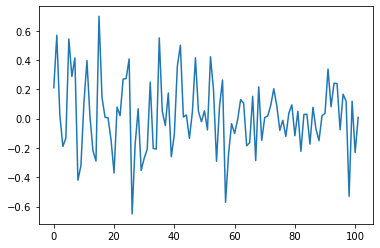

In [9]:
plt.plot(act_40_lh_mean-act_40_rh_mean)

bankssts-rh
cuneus-lh
fusiform-rh
lateraloccipital-lh
lingual-rh
parahippocampal-rh


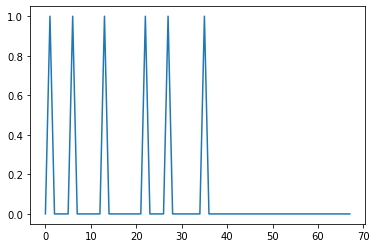

In [10]:
# print('The p-value of L/R difference is: '+str(ttest_rel(act_40_lh_mean,act_40_rh_mean,axis=0).pvalue))
pval = ttest_ind(act_40,act_rand,axis=0).pvalue
plt.plot(np.where(pval<0.05,1,0))
for i in range(68):
    if pval[i] <0.05 :
        print(label_names[i])
# fig, ax = plt.subplots()
# ax.pcolormesh(act_40_lh-act_40_rh)

In [11]:
from statsmodels.stats.multitest import *
def tri_flatten(arr):
    ret = []
    for i in range(1,arr.shape[0]):
        for j in range(i):
            ret.append(arr[i,j])
    return ret
def tri_unflatten(arr,shape):
    ret = np.zeros(shape)
    u = 0
    for i in range(1,shape[0]):
        for j in range(i):
            ret[i,j] = arr[u]
            ret[j,i] = arr[u]
            u += 1
    for i in range(shape[0]):
        ret[i,i] = 1
    return ret


In [12]:
def myfdr(pval,alpha=0.05):
    pval_idx = np.argsort(pval)
    pval_sort = np.array(pval)[pval_idx]
    m = len(pval)
    qval = np.zeros(m)
    for i in range(m):
        qval[i] = pval_sort[i]*m/(i+1)
    return qval[pval_idx]


In [13]:
norm_40_count = 0
norm_rand_count = 0
for i in range(1,68):
    for j in range(i):
        pvals = shapiro(cons_40[:,i,j]).pvalue
        if pvals > 0.05:
            norm_40_count += 1
for i in range(1,68):
    for j in range(i):
        pvals = shapiro(cons_rand[:,i,j]).pvalue
        if pvals > 0.05:
            norm_rand_count += 1
print(norm_40_count/68**2)
print(norm_rand_count/68**2)


0.24113321799307957
0.22902249134948097


[[0.         0.78412628 0.45237541 ... 0.2942524  0.5216732  0.86948776]
 [0.78412628 1.         0.95632935 ... 0.3682766  0.31179428 0.47490501]
 [0.45237541 0.95632935 1.         ... 0.17685318 0.47490501 0.43043327]
 ...
 [0.2942524  0.3682766  0.17685318 ... 1.         0.10539818 0.54587555]
 [0.5216732  0.31179428 0.47490501 ... 0.10539818 1.         0.17685318]
 [0.86948776 0.47490501 0.43043327 ... 0.54587555 0.17685318 1.        ]]
[[1.         1.24623132 1.60318924 ... 1.29871983 1.91361616 1.53210924]
 [1.24623132 1.         1.03830807 ... 1.36373713 3.3438923  1.18980581]
 [1.60318924 1.03830807 1.         ... 1.34476839 1.34456089 1.04743158]
 ...
 [1.29871983 1.36373713 1.34476839 ... 1.         1.86023028 1.04826272]
 [1.91361616 3.3438923  1.34456089 ... 1.86023028 1.         1.25620672]
 [1.53210924 1.18980581 1.04743158 ... 1.04826272 1.25620672 1.        ]]
3.8496170043945312
(array([53, 57]), array([57, 53]))


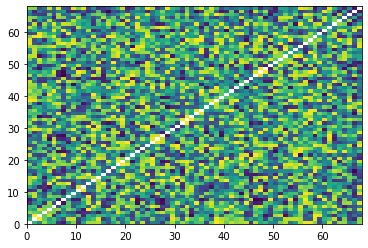

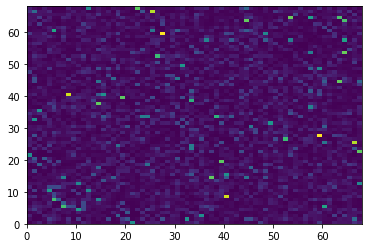

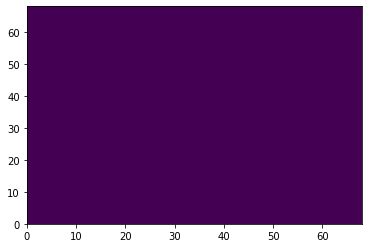

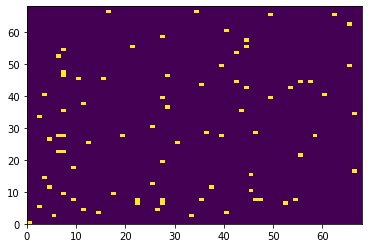

In [14]:
pval = ttest_rel(cons_40,cons_rand,axis=0).pvalue
pval_mat=np.where(pval>0.95,pval-0.95,0)
fig, ax = plt.subplots()
ax.pcolormesh(pval)
pval_uc = np.zeros((68,68))
for i in range(1,68):
    for j in range(i):
        pval_uc[i,j] = wilcoxon(cons_40[:,i,j],cons_rand[:,i,j]).pvalue
        pval_uc[j,i] = pval_uc[i,j]
    pval_uc[i,i] = 1
# pval = 1-tri_unflatten(fdrcorrection(tri_flatten(pval_uc),alpha=0.05,is_sorted=False,method='i')[1],(68,68))
pval = tri_unflatten(myfdr(tri_flatten(pval_uc)),(68,68))
print(pval_uc)
print(pval)
print(np.min(tri_flatten(pval_uc))*len(tri_flatten(pval_uc)))
print(np.where(pval==(np.min(tri_flatten(pval_uc))*len(tri_flatten(pval_uc)))))
fig, ax = plt.subplots()
ax.pcolormesh(pval)
fig, ax = plt.subplots()
ax.pcolormesh(np.where(pval<0.05,1,0))
fig, ax = plt.subplots()
ax.pcolormesh(np.where(pval_uc<0.05,1,0))

In [17]:
result_dir = op.join(dataRoot, 'result','overall')
if not op.exists(result_dir):
    os.makedirs(result_dir)
# First, we reorder the labels based on their location in the left hemi
label_names = [label.name for label in labels]

lh_labels = [name for name in label_names if name.endswith('lh')]

# Get the y-location of the label
label_ypos = list()
for name in lh_labels:
    idx = label_names.index(name)
    ypos = np.mean(labels[idx].pos[:, 1])
    label_ypos.append(ypos)

# Reorder the labels based on their location
lh_labels = [label for (yp, label) in sorted(zip(label_ypos, lh_labels))]

# For the right hemi
rh_labels = [label[:-2] + 'rh' for label in lh_labels]

# Save the plot order and create a circular layout
node_order = list()
node_order.extend(lh_labels[::-1])  # reverse the order
node_order.extend(rh_labels)
# node_order = node_order[:69]

node_angles = circular_layout(label_names, node_order, start_pos=90,
                              group_boundaries=[0, len(label_names) / 2])

# Plot the graph using node colors from the FreeSurfer parcellation. We only
# show the 300 strongest connections.
# fig,ax=plot_connectivity_circle(cons_40.mean(axis=0), label_names,padding=10, n_lines=300,
#                          node_angles=node_angles,facecolor='white', node_colors=label_colors, 
#                          title='All-to-All Connectivity 40 Hz '
#                                'Condition (PLI)')
# fig.savefig(op.join(result_dir,'40-connectivity.png'),dpi=300,facecolor='black')
# fig,ax=plot_connectivity_circle(cons_rand.mean(axis=0), label_names,padding=10, n_lines=300,
#                          node_angles=node_angles,facecolor='white', node_colors=label_colors, 
#                          title='All-to-All Connectivity Random '
#                                'Condition (PLI)')
# fig.savefig(op.join(result_dir,'rand-connectivity.png'),dpi=300,facecolor='black')
dcon_res = cons_40.mean(axis=0) - cons_rand.mean(axis=0)
# fig,ax=plot_connectivity_circle(np.where(dcon_res<0,0,dcon_res), label_names,padding=10, n_lines=300,
#                          node_angles=node_angles,facecolor='white', node_colors=label_colors, colormap='hot', 
#                          title='All-to-All Connectivity Upregulated '
#                                '(PLI)')
# fig.savefig(op.join(result_dir,'up-connectivity.png'),dpi=300,facecolor='black')
# fig,ax=plot_connectivity_circle(np.where(dcon_res>0,0,-1*dcon_res), label_names,padding=10, n_lines=300,
#                          node_angles=node_angles,facecolor='white', node_colors=label_colors, colormap='gray',
#                          title='All-to-All Connectivity Downregulated '
#                                '(PLI)')
# fig.savefig(op.join(result_dir,'down-connectivity.png'),dpi=300,facecolor='black')


In [31]:
from mne import vertex_to_mni
lh_labels = [label for label in labels if label.name.endswith('lh')]
rh_labels = [label for label in labels if label.name.endswith('rh')]
with open('aparc.txt','w') as f:
    for label in lh_labels[::-1]:
        print(label)
        vertex = label.center_of_mass()
        mni = vertex_to_mni(vertex,0 if label.hemi=='lh' else 1,'fsaverage')
        print(mni)
        f.write('%f %f %f\n'%(mni[0],mni[1],mni[2]))
    for label in rh_labels:
        print(label)
        vertex = label.center_of_mass()
        mni = vertex_to_mni(vertex,0 if label.hemi=='lh' else 1,'fsaverage')
        print(mni)
        f.write('%f %f %f\n'%(mni[0],mni[1],mni[2]))
with open('label-name.txt','w') as f:
    for label in lh_labels[::-1]:
        f.write('%s\n'%label.name)
    for label in rh_labels:
        f.write('%s\n'%label.name)


<Label | fsaverage, 'transversetemporal-lh', lh : 1064 vertices>
[-44.49132538 -23.69833755   8.14447212]
<Label | fsaverage, 'temporalpole-lh', lh : 839 vertices>
[-29.67376137  12.63781548 -36.78151321]
<Label | fsaverage, 'supramarginal-lh', lh : 8600 vertices>
[-57.26780319 -38.42873383  36.91706085]
<Label | fsaverage, 'superiortemporal-lh', lh : 7271 vertices>
[-61.35938644 -12.9416256    0.38713917]
<Label | fsaverage, 'superiorparietal-lh', lh : 10456 vertices>
[-23.15476418 -62.10996246  52.27984619]
<Label | fsaverage, 'superiorfrontal-lh', lh : 12179 vertices>
[-6.83482075 30.37921143 52.34886932]
<Label | fsaverage, 'rostralmiddlefrontal-lh', lh : 7243 vertices>
[-34.52772522  45.38170242  18.76058197]
<Label | fsaverage, 'rostralanteriorcingulate-lh', lh : 1350 vertices>
[-7.03762054e+00  3.63499641e+01  1.28178596e-02]
<Label | fsaverage, 'precuneus-lh', lh : 7308 vertices>
[ -7.31799555 -58.57407379  36.39716339]
<Label | fsaverage, 'precentral-lh', lh : 10740 vertices>


/work/zhangyq/intel/oneapi/intelpython/latest/envs/mne/lib/python3.9/site-packages/mne/viz/circle.py:352: RuntimeWarning: invalid value encountered in true_divide
  con_val_scaled = (con - vmin) / vrange


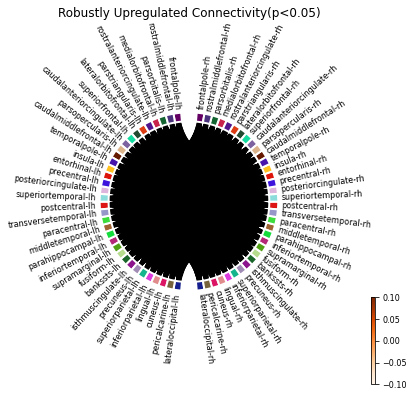

0.05u


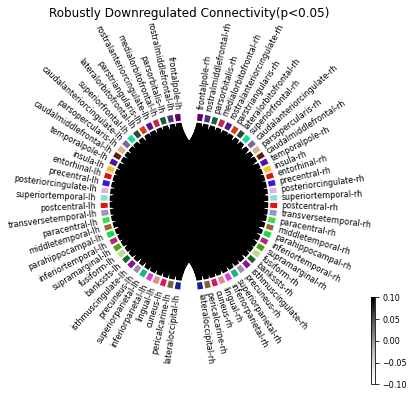

0.05d


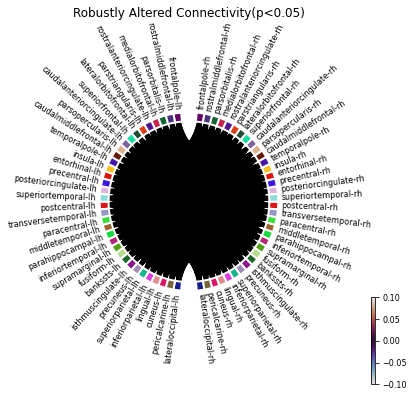

0.05


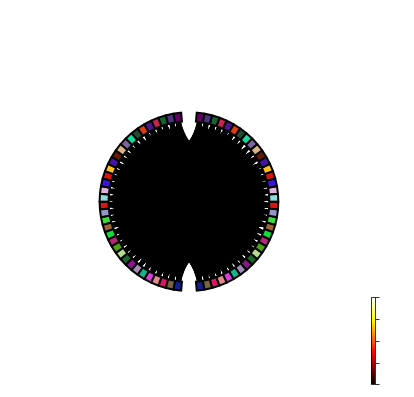

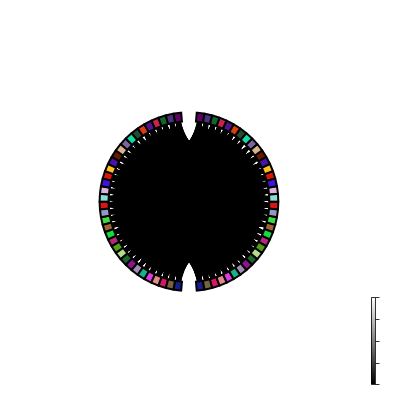

In [ ]:
from statsmodels.stats.multitest import multipletests
result_dir = op.join(dataRoot, 'result','overall')
pval_uc = np.zeros((68,68))
for i in range(1,68):
    for j in range(i):
        pval_uc[i,j] = wilcoxon(cons_40[:,i,j],cons_rand[:,i,j]).pvalue
        pval_uc[j,i] = pval_uc[i,j]
    pval_uc[i,i] = 1
# pval = 1-tri_unflatten(fdrcorrection(tri_flatten(pval_uc),alpha=0.05,is_sorted=False,method='i')[1],(68,68))
pval = 1 - tri_unflatten(myfdr(tri_flatten(pval_uc)),(68,68))
pval_mat = np.where(pval>0.95,1-pval,0)
plot_mat = np.zeros(pval_mat.shape)
for i in range(pval_mat.shape[0]):
      for j in range(pval_mat.shape[1]):
            if not pval_mat[i,j]==0:
                  plot_mat[i,j] = np.where(dcon_res<0,0,dcon_res)[i,j]
fig,ax=plot_connectivity_circle(plot_mat, label_names,padding=10, n_lines=300,
                         node_angles=node_angles,facecolor='white',textcolor='black',node_edgecolor='white', node_colors=label_colors, colormap='Oranges', 
                         title='Robustly Upregulated Connectivity'
                               '(p<0.05)')
fig.savefig(op.join(result_dir,'0.05u.svg'),dpi=300,facecolor='white')
print('0.05u')
for i in range(pval_mat.shape[0]):
      for j in range(pval_mat.shape[1]):
            if not pval_mat[i,j]==0:
                  plot_mat[i,j] = np.where(dcon_res>0,0,-1*dcon_res)[i,j]
fig,ax=plot_connectivity_circle(plot_mat, label_names,padding=10, n_lines=300,
                         node_angles=node_angles,facecolor='white',textcolor='black',node_edgecolor='white', node_colors=label_colors, colormap='Greys', 
                         title='Robustly Downregulated Connectivity'
                               '(p<0.05)')
fig.savefig(op.join(result_dir,'0.05d.svg'),dpi=300,facecolor='white')
print('0.05d')
for i in range(pval_mat.shape[0]):
      for j in range(pval_mat.shape[1]):
            if not pval_mat[i,j]==0:
                  plot_mat[i,j] = dcon_res[i,j]
fig,ax=plot_connectivity_circle(plot_mat, label_names, vmax = np.max(np.abs(plot_mat)),vmin=np.max(np.abs(plot_mat))*-1,padding=10, n_lines=300,
                         node_angles=node_angles,facecolor='white',textcolor='black',node_edgecolor='white', node_colors=label_colors, colormap='twilight', 
                         title='Robustly Altered Connectivity'
                               '(p<0.05)')
fig.savefig(op.join(result_dir,'0.05.svg'),dpi=300,facecolor='white')
print('0.05')
pval = multipletests(pval_uc.flatten(),alpha=0.01,is_sorted=False,method='fdr_bh')[1].reshape((68,68))
pval_mat = np.where(pval>0.99,1-pval,0)
plot_mat = np.zeros(pval_mat.shape)
for i in range(pval_mat.shape[0]):
      for j in range(pval_mat.shape[1]):
            if not pval_mat[i,j]==0:
                  plot_mat[i,j] = np.where(dcon_res<0,0,dcon_res)[i,j]
fig,ax=plot_connectivity_circle(plot_mat, label_names,padding=10, n_lines=300,
                         node_angles=node_angles,facecolor='white', node_colors=label_colors, colormap='hot', 
                         title='Robustly Upregulated Connectivity'
                               '(p<0.01)')
fig.savefig(op.join(result_dir,'0.01u.svg'),dpi=300,facecolor='black')

plot_mat = np.zeros(pval_mat.shape)
for i in range(pval_mat.shape[0]):
      for j in range(pval_mat.shape[1]):
            if not pval_mat[i,j]==0:
                  plot_mat[i,j] = np.where(dcon_res>0,0,-1*dcon_res)[i,j]
fig,ax=plot_connectivity_circle(plot_mat, label_names,padding=10, n_lines=300,
                         node_angles=node_angles,facecolor='white', node_colors=label_colors, colormap='gray', 
                         title='Robustly Downregulated Connectivity'
                               '(p<0.01)')
fig.savefig(op.join(result_dir,'0.01d.svg'),dpi=300,facecolor='black')

# for i in range(pval_mat.shape[0]):
#       for j in range(pval_mat.shape[1]):
#             if not pval_mat[i,j]==0:
#                   plot_mat[i,j] = dcon_res[i,j]
# fig,ax=plot_connectivity_circle(plot_mat, label_names, vmax = np.max(np.abs(plot_mat)),vmin=np.max(np.abs(plot_mat))*-1,padding=10, n_lines=300,
#                          node_angles=node_angles,facecolor='white', node_colors=label_colors, colormap='twilight', 
#                          title='Robustly Altered Connectivity'
#                                '(p<0.01)')
# fig.savefig(op.join(result_dir,'0.01.svg'),dpi=300,facecolor='black')
